# 网络的验证

这种验证其实也就有些类似于目标检测的验证了，比分类问题复杂些，通过一些指标而非简单的分类标签来判定真伪。

如果先不看ggcnn中的思路，这块让我来做的话，分析一下，我们得到的网络输出是pos_img,ang_img和width_img，pos_img各点的值可以视作该点可抓不可抓的概率，图像大小为（300，300），太多了，那么我首先可以把最大值的1000个点筛选出来，然后找对对应的angle和width，凭借这三个参数就可以重建出这些点的抓取框，然后计算与真实各框的iou和jaccard指数等，如果都满足标准，就认为这是一次正确的抓取，这次预测也就是正确的了。

那就开整，流程应该是这样的：
- 首先是从网络的输出映射图中反求出各个实际参数代表的抓取框，主要就是要将cos和sin两个图反求出angle。
- 然后要明确一下成功的标准，然后写函数计算这些标准，最后再集成到类或者函数里面，思路还是很明确的。
  - 1.IoU
  - 2.jaccard index

## 1.数据的反求

首先是通过原始的输出映射四张图把数据读出来，这边我们先运行一个训练，得到一下训练输出，然后方便处理

In [8]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from train.cornell_pro import Cornell
from train.ggcnn import GGCNN

#准备数据集
cornell_data = Cornell('cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32)

#从数据集中读取一个样本
for x,y in dataset:
    xc = x
    yc = y
    break
    
#实例化一个网络
net = GGCNN(4)

#定义一个优化器
optimizer = optim.Adam(net.parameters())

#为了能够看出效果，就在这个样本上多训练几次，得到一个很擅长这个样本的模型，然后拿它做预测输出

for i in range(50):
    losses = net.compute_loss(xc,yc)
    
    loss = losses['loss']
    print(i,loss)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()



0 tensor(1.2436, grad_fn=<AddBackward0>)
1 tensor(1.2214, grad_fn=<AddBackward0>)
2 tensor(1.1963, grad_fn=<AddBackward0>)
3 tensor(1.1675, grad_fn=<AddBackward0>)
4 tensor(1.1340, grad_fn=<AddBackward0>)
5 tensor(1.0918, grad_fn=<AddBackward0>)
6 tensor(1.0340, grad_fn=<AddBackward0>)
7 tensor(0.9526, grad_fn=<AddBackward0>)
8 tensor(0.8400, grad_fn=<AddBackward0>)
9 tensor(0.6923, grad_fn=<AddBackward0>)
10 tensor(0.5193, grad_fn=<AddBackward0>)
11 tensor(0.3677, grad_fn=<AddBackward0>)
12 tensor(0.3363, grad_fn=<AddBackward0>)
13 tensor(0.3998, grad_fn=<AddBackward0>)
14 tensor(0.3224, grad_fn=<AddBackward0>)
15 tensor(0.2055, grad_fn=<AddBackward0>)
16 tensor(0.1439, grad_fn=<AddBackward0>)
17 tensor(0.1357, grad_fn=<AddBackward0>)
18 tensor(0.1468, grad_fn=<AddBackward0>)
19 tensor(0.1546, grad_fn=<AddBackward0>)
20 tensor(0.1523, grad_fn=<AddBackward0>)
21 tensor(0.1429, grad_fn=<AddBackward0>)
22 tensor(0.1338, grad_fn=<AddBackward0>)
23 tensor(0.1339, grad_fn=<AddBackward0>)
24

In [9]:
#将输入传递到网络并计算输出
pos,cos,sin,width = net.forward(xc)

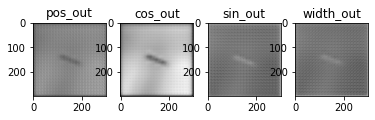

In [12]:
#看一下是否能够给出一个相对合理的预测
num = 20

plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[num][0].data.numpy(),cmap=plt.cm.gray)
plt.show()
#看起来还不错，下面开始数据的读取和反求

## 2.标准的确定
### 2.1 IoU的计算
全称Intersection over Union
![IoU计算示意图](images/iou.png)

计算IoU程序的设计思路可以参考：https://blog.csdn.net/u014061630/article/details/82818112